In [1]:
from ciw.dists import Exponential
from kmodes.kprototypes import KPrototypes
from scipy import special, stats
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from yellowbrick.utils import KneeLocator

import ciw
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("default")
plt.style.use("seaborn-colorblind")

prop_cycle = plt.rcParams['axes.prop_cycle']
colours = prop_cycle.by_key()['color']


In [2]:
copd = pd.read_csv(
    "/Volumes/thesis-data/copd.csv", parse_dates=["admission_date", "discharge_date"]
)


In [3]:
for col in copd.columns:
    if copd[col].isnull().sum() > .25 * len(copd):
        copd = copd.drop(col, axis=1)

copd = copd[copd["true_los"] <= 365]
copd = copd.dropna()


In [4]:
clinicals = [
    "n_spells",
    "n_wards",
    "n_consultants",
    "true_los",
    "n_pr_attendances",
    "n_sn_attendances",
    "n_copd_admissions_last_year",
    "charlson_gross",
    "n_icds",
    "intervention",
    "day_of_week",
    "gender",
]

codes = [
    "infectious",
    "neoplasms",
    "blood",
    "endocrine",
    "mental",
    "nervous",
    "eye",
    "ear",
    "circulatory",
    "respiratory",
    "digestive",
    "skin",
    "muscoloskeletal",
    "genitourinary",
    "perinatal",
    "congenital",
    "abnormal_findings",
    "injury",
    "external_causes", 
    "contact_factors",
    "special_use",
]

conditions = [
    "ami",
    "cva",
    "chf",
    "ctd",
    "dementia",
    "diabetes",
    "liver_disease",
    "peptic_ulcer",
    "pvd",
    "pulmonary_disease",
    "cancer",
    "diabetic_complications",
    "paraplegia",
    "renal_disease",
    "metastatic_cancer",
    "sever_liver_disease",
    "hiv",
    "cdiff",
    "mrsa",
    "obese",
    "sepsis",
]

cols = clinicals + codes + conditions
data = copd[cols].copy()

categorical = [
    i
    for i, (col, dtype) in enumerate(dict(data.dtypes).items())
    if dtype == "object"
]


In [5]:
cols

['n_spells',
 'n_wards',
 'n_consultants',
 'true_los',
 'n_pr_attendances',
 'n_sn_attendances',
 'n_copd_admissions_last_year',
 'charlson_gross',
 'n_icds',
 'intervention',
 'day_of_week',
 'gender',
 'infectious',
 'neoplasms',
 'blood',
 'endocrine',
 'mental',
 'nervous',
 'eye',
 'ear',
 'circulatory',
 'respiratory',
 'digestive',
 'skin',
 'muscoloskeletal',
 'genitourinary',
 'perinatal',
 'congenital',
 'abnormal_findings',
 'injury',
 'external_causes',
 'contact_factors',
 'special_use',
 'ami',
 'cva',
 'chf',
 'ctd',
 'dementia',
 'diabetes',
 'liver_disease',
 'peptic_ulcer',
 'pvd',
 'pulmonary_disease',
 'cancer',
 'diabetic_complications',
 'paraplegia',
 'renal_disease',
 'metastatic_cancer',
 'sever_liver_disease',
 'hiv',
 'cdiff',
 'mrsa',
 'obese',
 'sepsis']

In [6]:
# # APPROX. 40 minute runtime.

# knee_results = []
# cluster_range = range(2, 9)
# for n_clusters in tqdm(cluster_range):

#     kp = KPrototypes(n_clusters, init="cao", random_state=0, n_jobs=6)
#     kp.fit(data, categorical=categorical)

#     knee_results.append(kp.cost_)

In [7]:
# kl = KneeLocator(
#     cluster_range,
#     knee_results,
#     curve_nature="convex",
#     curve_direction="decreasing",
# )

# n_clusters = kl.knee

# with open("../data/n_clusters.txt", "w") as f:
#     f.write(str(n_clusters))

# knee_results = pd.Series(index=cluster_range, data=knee_results)
# knee_results.to_csv("../data/knee_results.csv", header=False)

In [8]:
knee_results = pd.read_csv("../data/knee_results.csv", header=None).set_index(0)
with open("../data/n_clusters.txt", "r") as f:
    n_clusters = int(f.read())

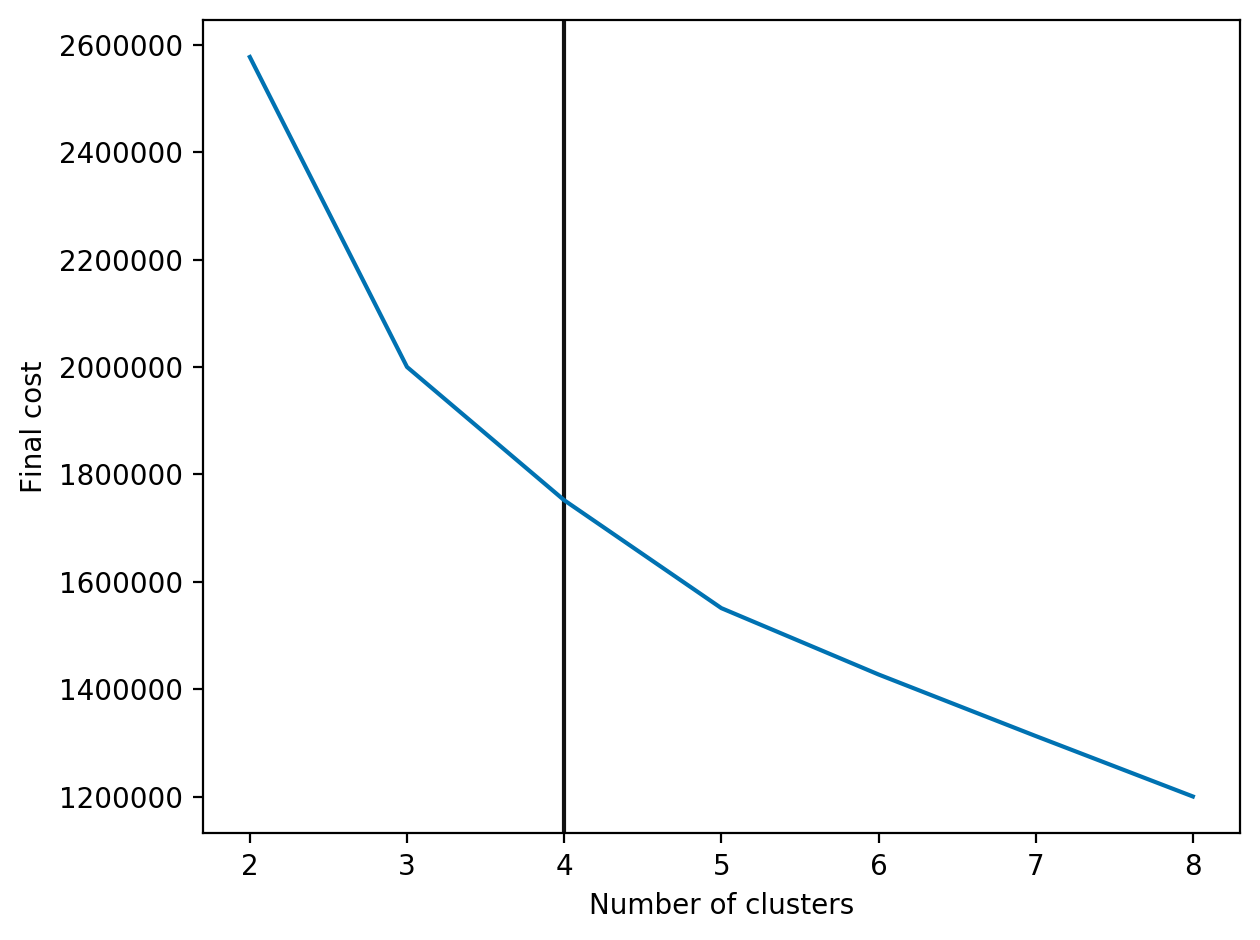

In [9]:
fig, ax = plt.subplots(dpi=200)

ax.plot(knee_results.index, knee_results.values)

ylims = ax.get_ylim()
ax.vlines(n_clusters, *ylims)

ax.set(
    xlabel="Number of clusters",
    ylabel="Final cost",
    ylim=ylims,
)

plt.tight_layout()
plt.savefig("../img/knee_results.pdf", transparent=True)

In [10]:
# kp = KPrototypes(n_clusters, init="matching", random_state=0, n_jobs=6, verbose=1)
# kp.fit(data, categorical=categorical)

# labels = kp.labels_
# copd["cluster"] = labels
# copd.to_csv("../data/copd_clustered.csv", index=False)

# knee_results.loc[n_clusters, 1], kp.cost_

In [11]:
copd = pd.read_csv("../data/copd_clustered.csv", parse_dates=["admission_date", "discharge_date"])

In [12]:
copd["cluster"].value_counts().sort_index()

0    1080
1    2096
2    7534
3     157
Name: cluster, dtype: int64

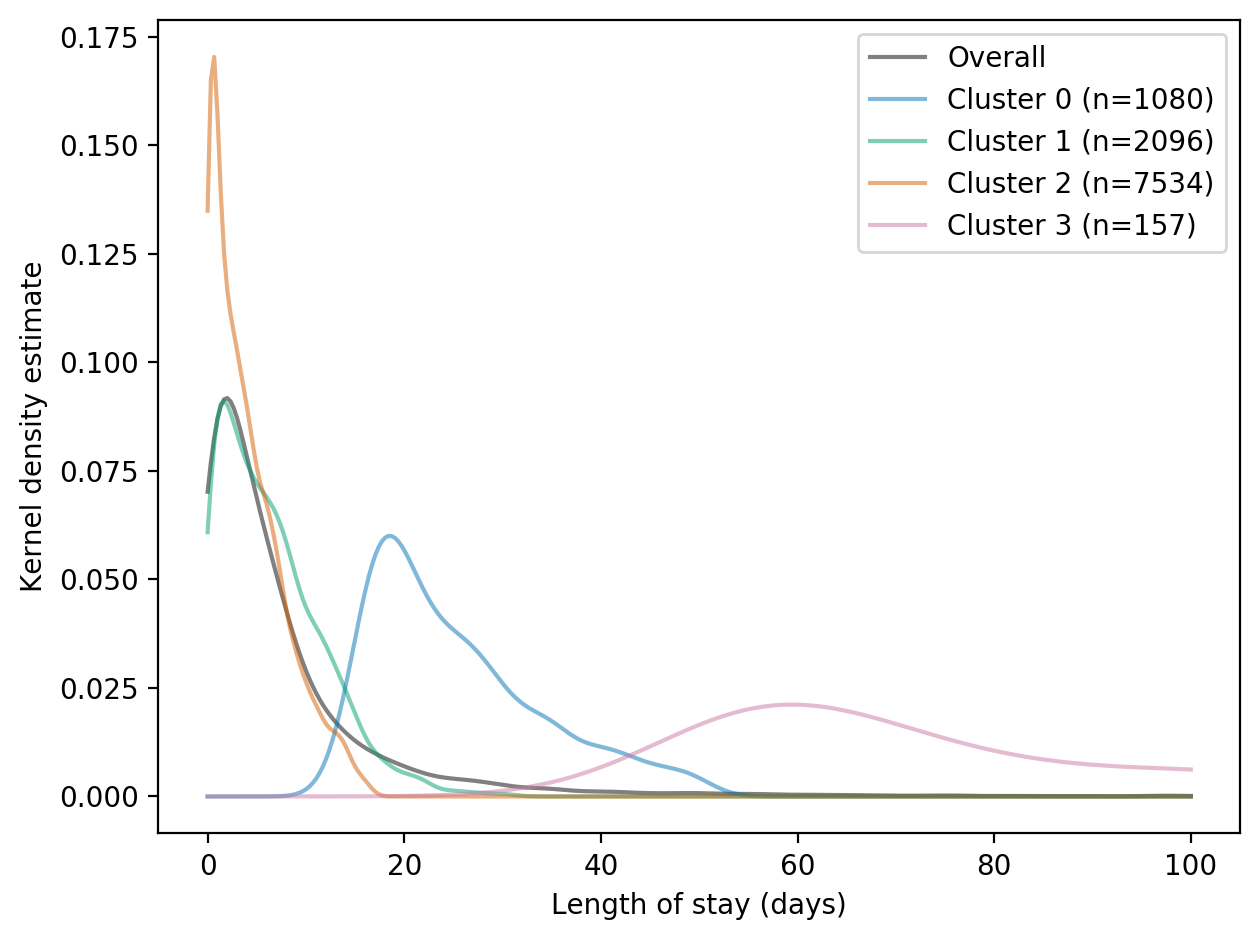

In [13]:
fig, ax = plt.subplots(dpi=200)

xs = np.linspace(0, 100, 300)
kernel = stats.gaussian_kde(copd["true_los"])
ax.plot(xs, kernel(xs), "gray", label="Overall")

for cluster, times in copd.groupby("cluster")["true_los"]:

    colour = colours[cluster]
    kernel = stats.gaussian_kde(times)
    ax.plot(
        xs,
        kernel(xs),
        alpha=0.5,
        color=colour,
        label=f"Cluster {cluster} (n={len(times)})",
    )

kde_ylims = ax.get_ylim()
    
ax.set(
    xlabel="Length of stay (days)",
    ylabel="Kernel density estimate",
    ylim=kde_ylims,
)

ax.legend()

plt.tight_layout()
plt.savefig("../img/cluster_los.pdf", transparent=True)

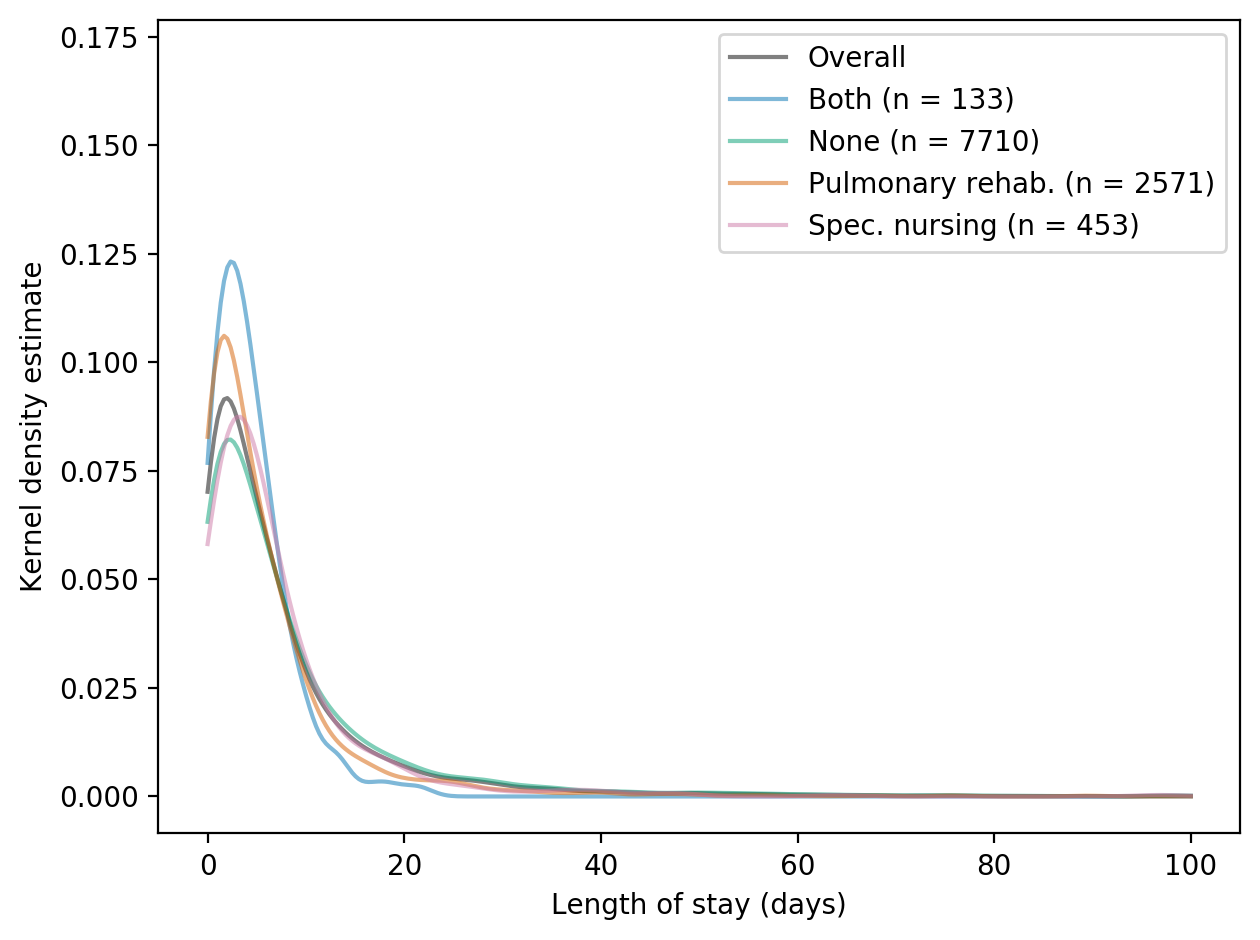

In [14]:
fig, ax = plt.subplots(dpi=200)

intervention_labels = {"none": "None", "both": "Both", "pr": "Pulmonary rehab.", "sn": "Spec. nursing"}

xs = np.linspace(0, 100, 300)
kernel = stats.gaussian_kde(copd["true_los"])
ax.plot(xs, kernel(xs), "gray", label="Overall")

for intervention, times in copd.groupby("intervention")["true_los"]:

    kernel = stats.gaussian_kde(times)
    ax.plot(
        xs,
        kernel(xs),
        alpha=0.5,
        label=f"{intervention_labels[intervention]} (n = {len(times)})",
    )

ax.set(
    xlabel="Length of stay (days)",
    ylabel="Kernel density estimate",
    ylim=kde_ylims,
)

ax.legend()

plt.tight_layout()
plt.savefig("../img/intervention_los.pdf", transparent=True)

In [15]:
def histograms(data, column, group="cluster", density=True, colours=colours):

    fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
    axes = axes.reshape(4)

    column_labels = {
        "wimd": "Welsh Index of Multiple Deprivation",
        "charlson_gross": "Charlson Comorbidity Index",
        "n_copd_admissions_last_year": "COPD admissions in last year",
        "n_icds": "No. of ICDs",
    }
    
    str_ints = (x for x in range(10))
    for (cluster, values), ax in zip(copd.groupby(group)[column], axes):

        ax.hist(
            copd[column],
            bins=9,
            facecolor="gray",
            alpha=0.2,
            density=True,
            label="Overall",
        )

        cluster_name = intervention_labels.get(cluster, f"Cluster {cluster}")
        if isinstance(cluster, str):
            cluster = next(str_ints)
        colour = colours[cluster]
        ax.hist(values, alpha=0.5, facecolor=colour, density=True, label=cluster_name)

        if cluster > 1:
            ax.set_xlabel(column_labels[column])
        if cluster % 2 == 0:
            ax.set_ylabel("Frequency density")

        ax.legend()

    plt.tight_layout()
    plt.savefig(f"../img/{group}_{column}.pdf", transparent=True)

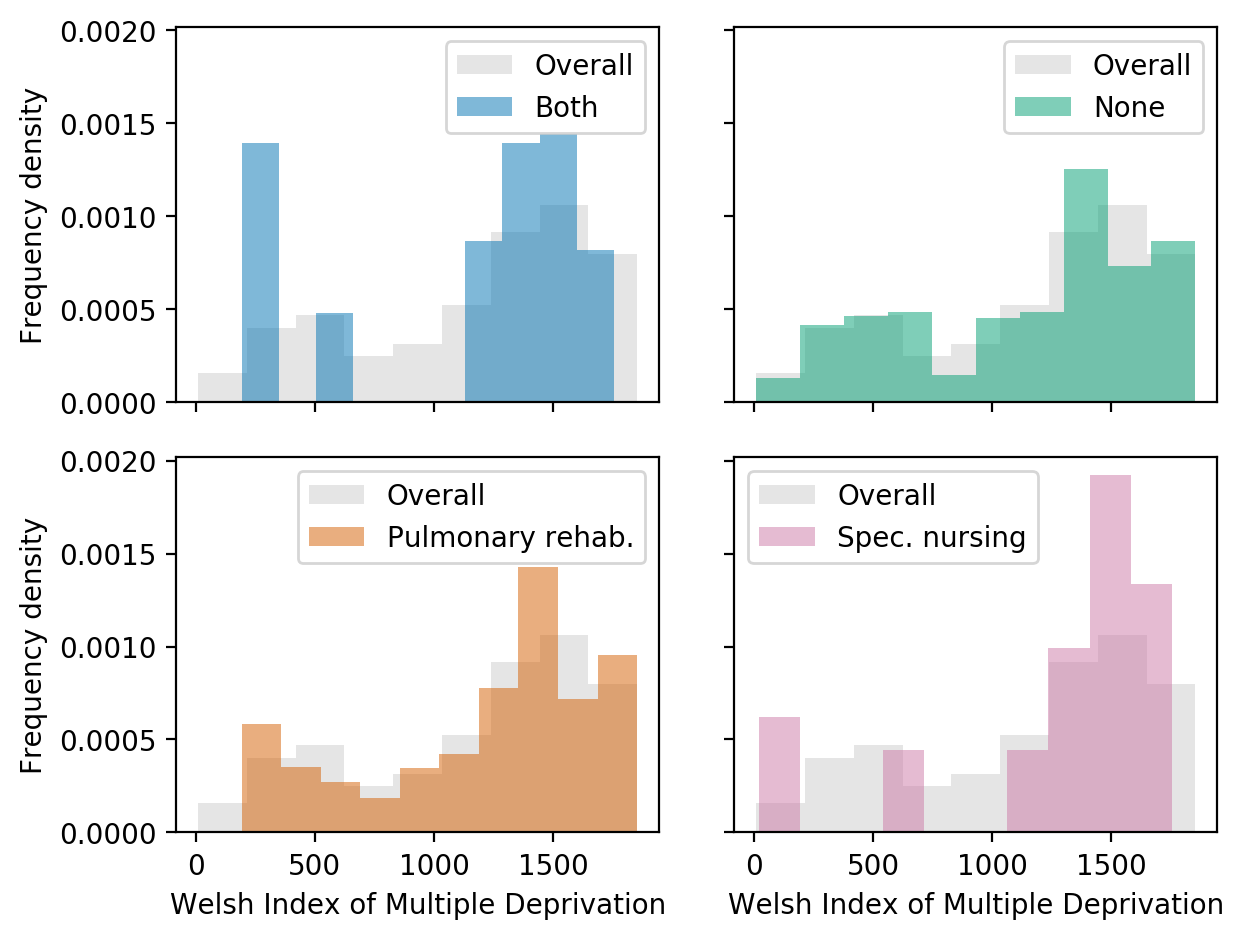

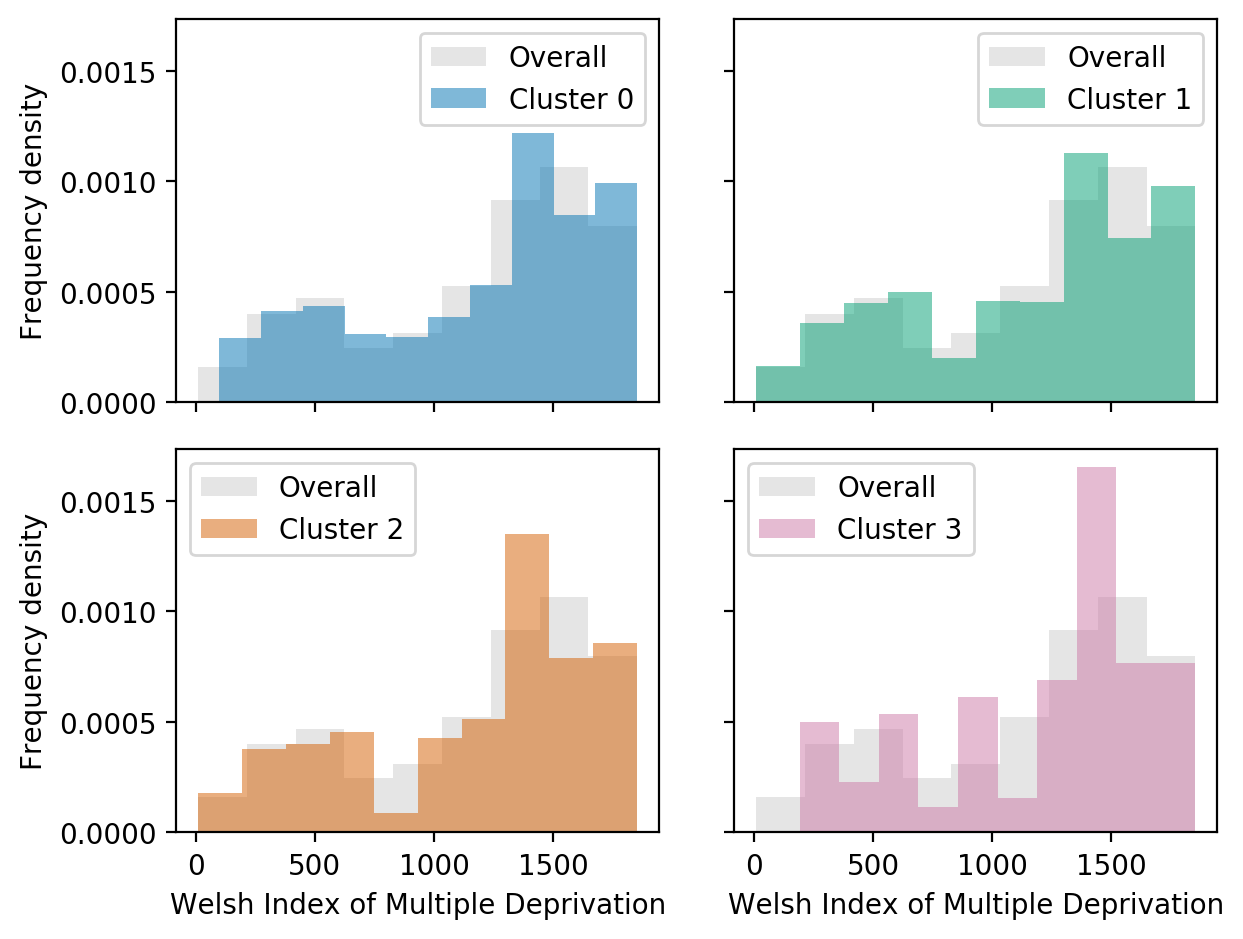

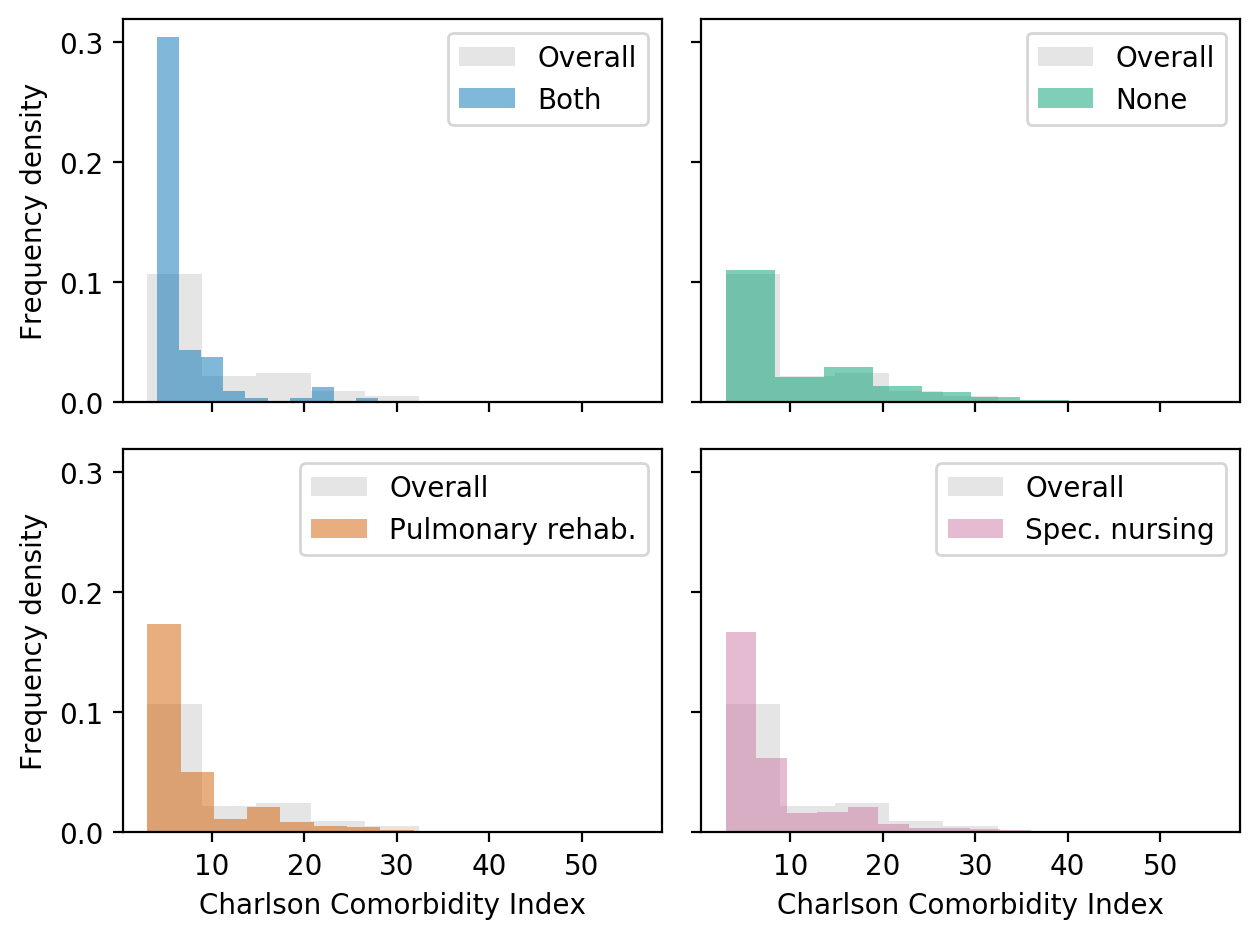

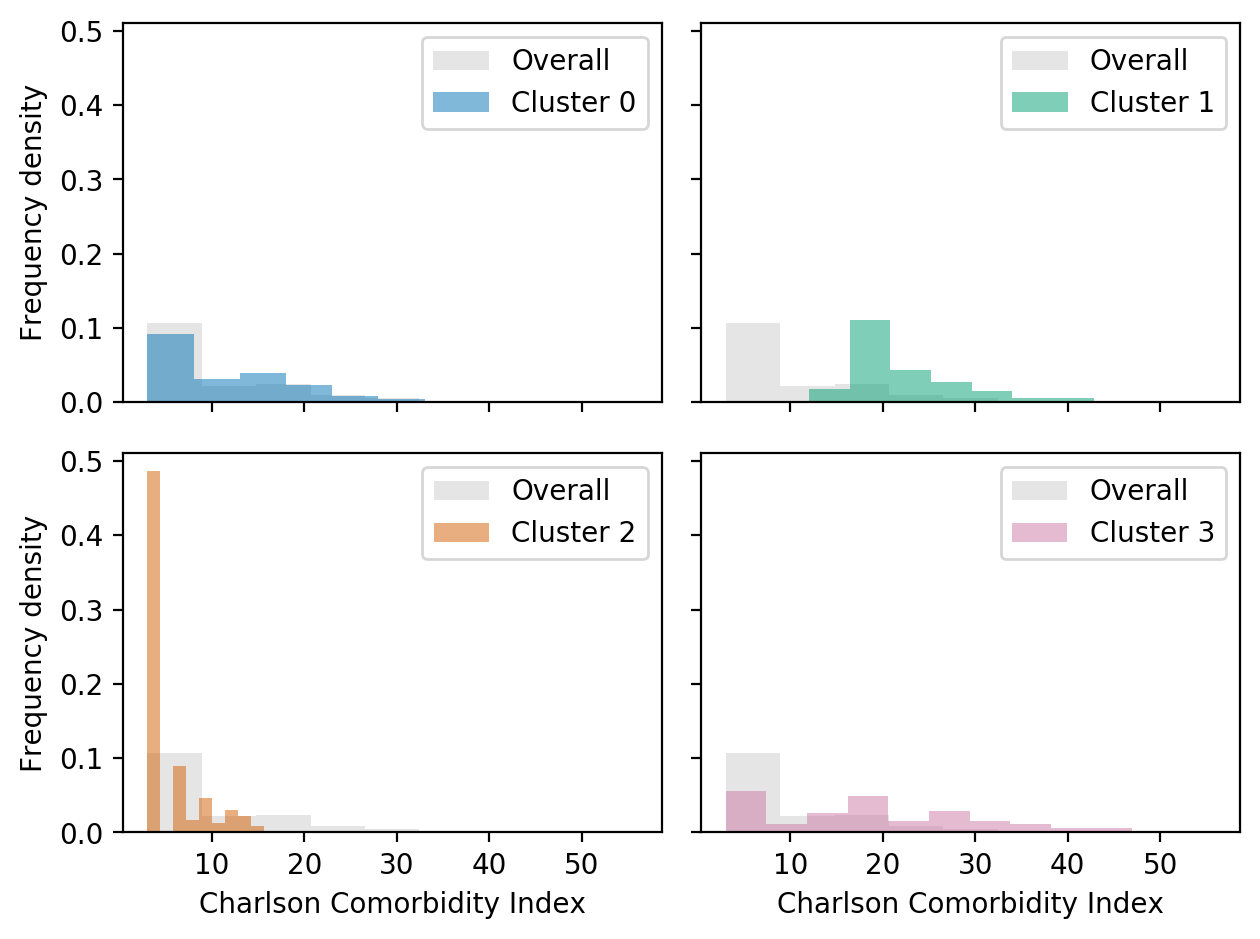

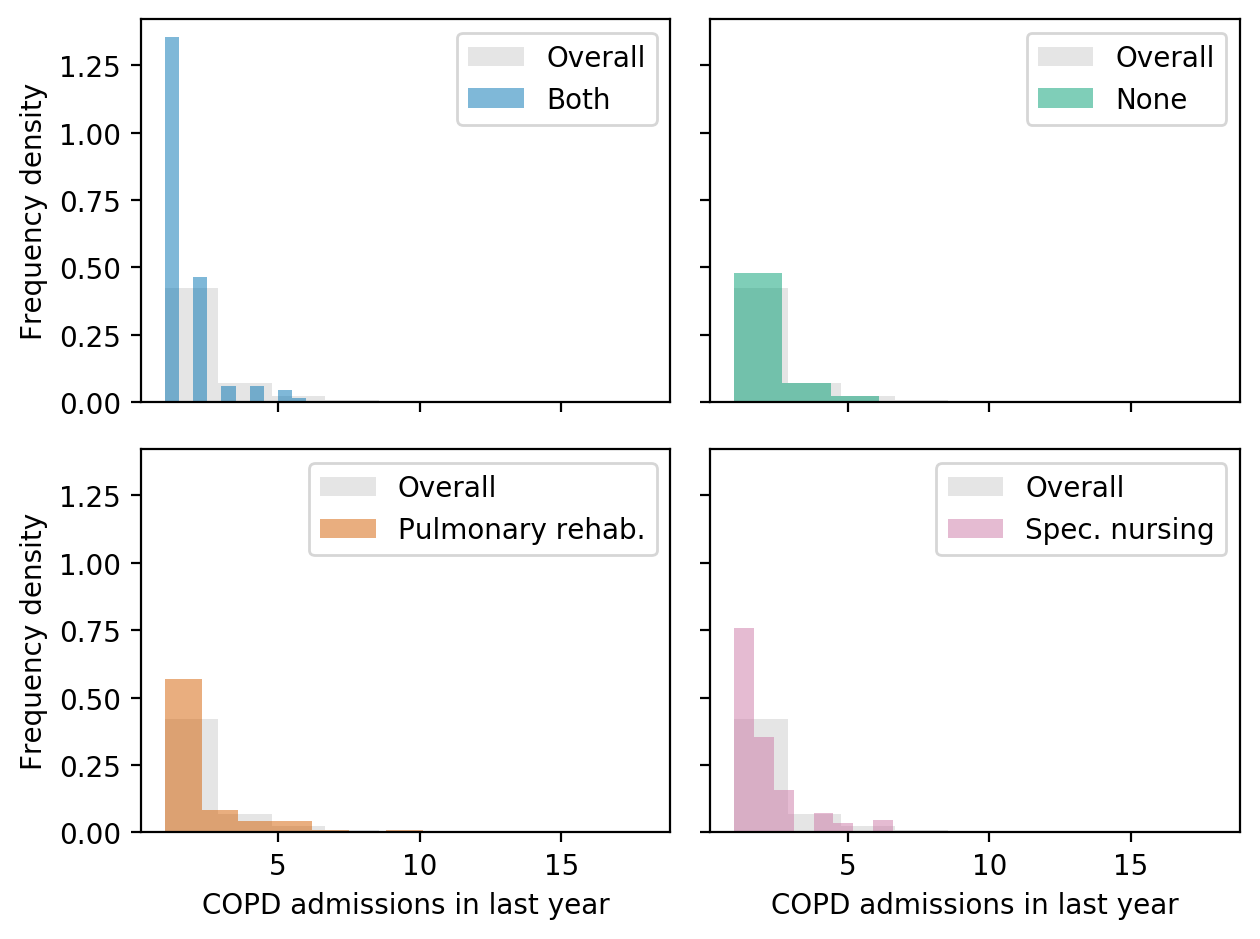

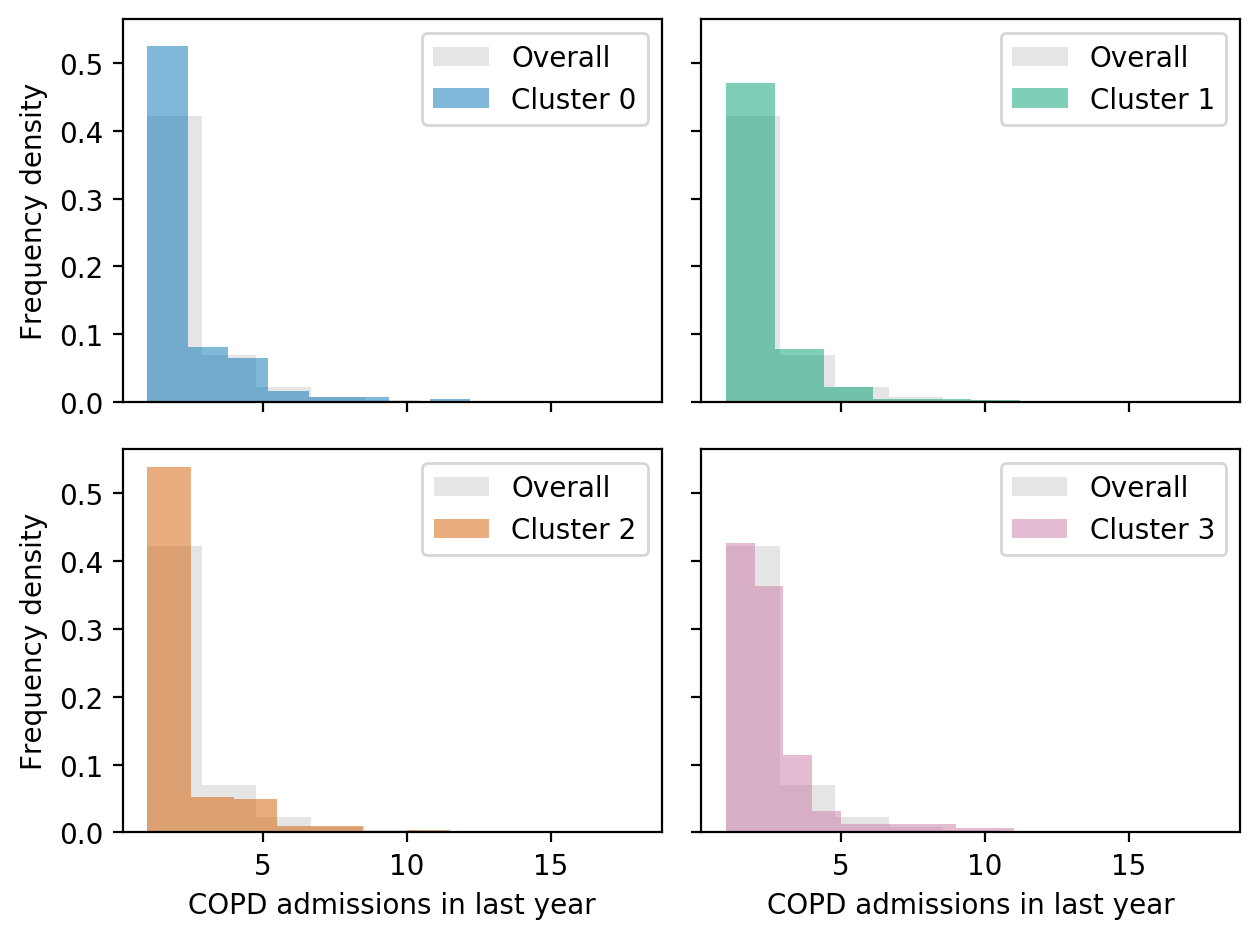

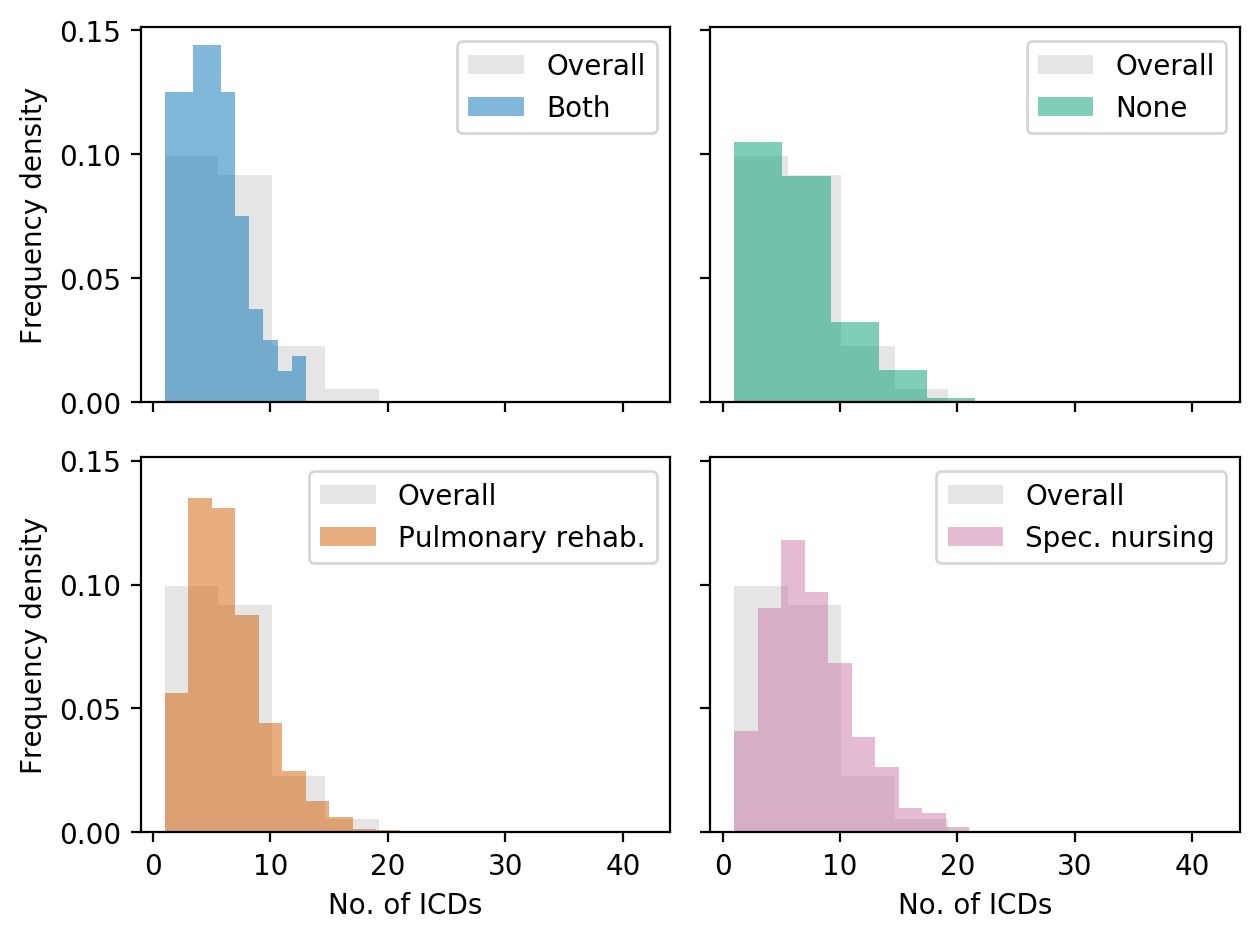

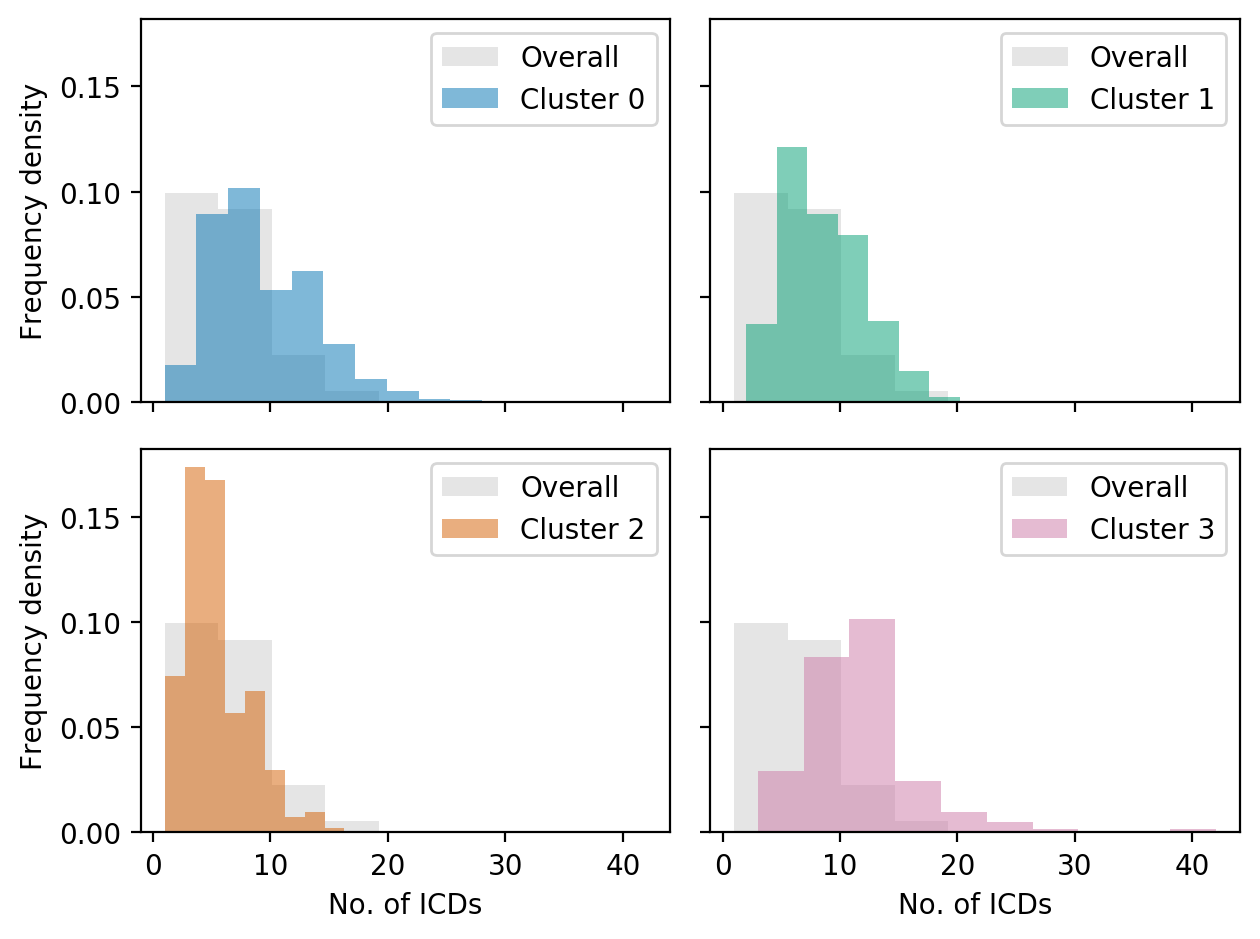

In [26]:
for col in [
    "wimd",
    "charlson_gross",
    "n_copd_admissions_last_year",
    "n_icds",
]:
    histograms(copd, col, group="intervention")
    histograms(copd, col, group="cluster")

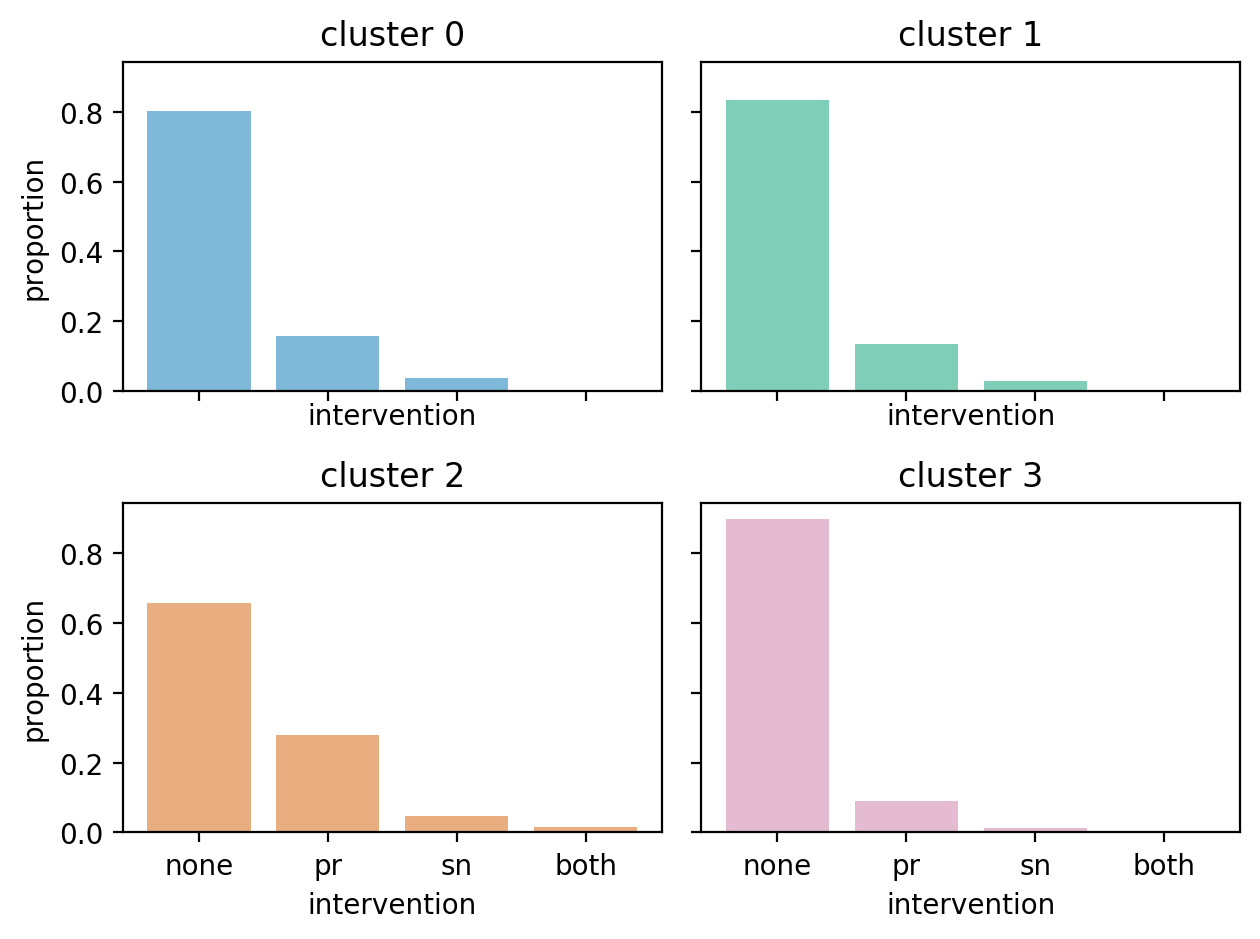

In [30]:
fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
axes = axes.reshape(4)

for i, ((cluster, values), ax) in enumerate(zip(copd.groupby("cluster")["intervention"], axes)):

    counts = values.value_counts(normalize=True).reindex(["none", "pr", "sn", "both"]).fillna(0)
    ax.bar(counts.index, counts.values, facecolor=colours[cluster], alpha=0.5)

    ax.set_xlabel("intervention")
    if i % 2 == 0:
        ax.set_ylabel("proportion")
    ax.set_title(f"cluster {cluster}")

plt.tight_layout()


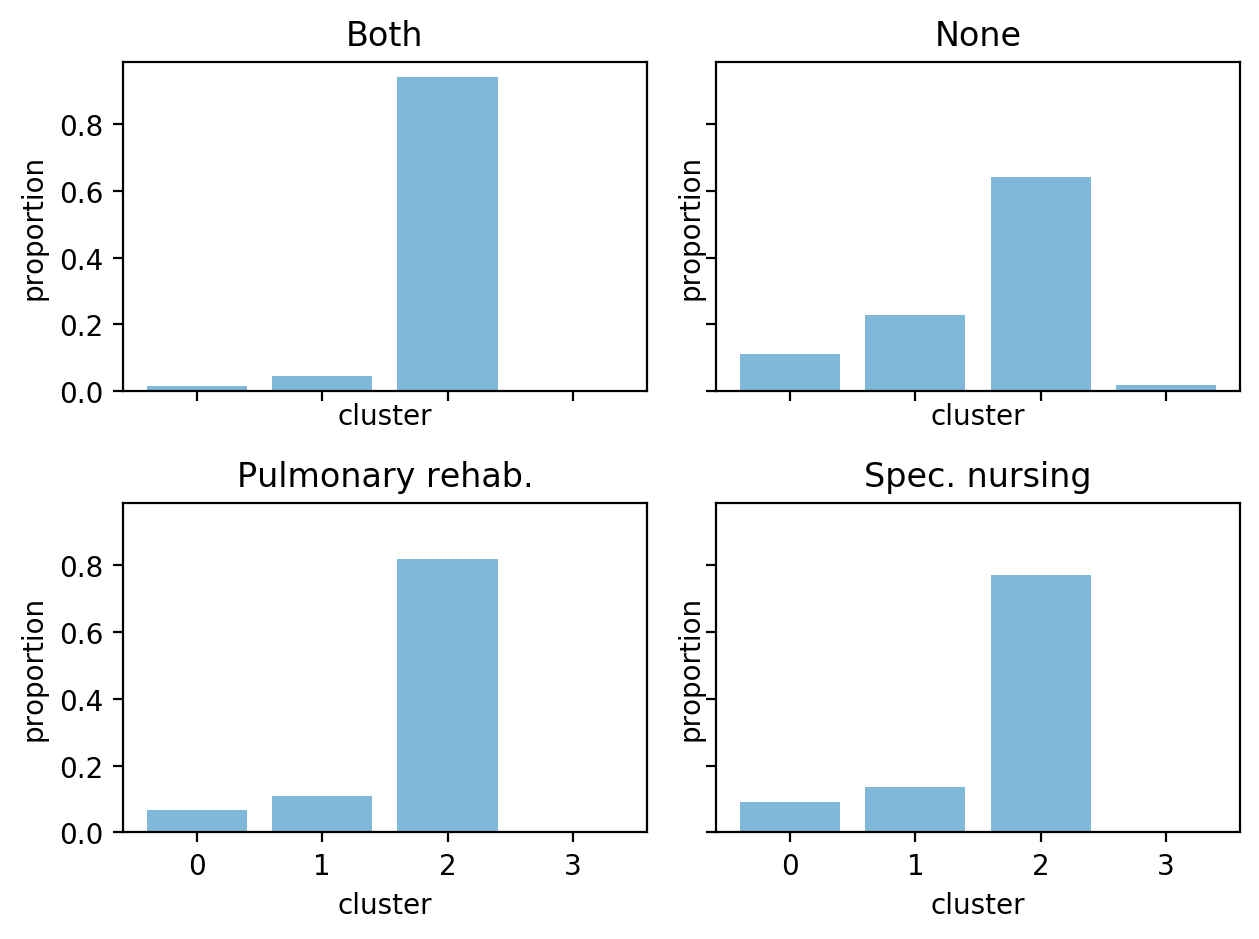

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
axes = axes.reshape(4)

for (intervention, values), ax in zip(copd.groupby("intervention")["cluster"], axes):

    counts = values.value_counts(normalize=True).sort_index().fillna(0)
    ax.bar(counts.index, counts.values, alpha=0.5)

    ax.set_xlabel("cluster")
    ax.set_ylabel("proportion")
    ax.set_title(intervention_labels[intervention])

plt.tight_layout()


In [19]:
cluster_attendances = pd.DataFrame({"Population": [copd.groupby("patient_id")["n_copd_admissions_last_year"].mean().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_attendances[label] = [cluster.groupby("patient_id")["n_copd_admissions_last_year"].mean().mean()]

cluster_mean_lengths = pd.DataFrame({"Population": [copd.groupby("patient_id")["true_los"].mean().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_mean_lengths[label] = [cluster.groupby("patient_id")["true_los"].mean().mean()]

cluster_min_lengths = pd.DataFrame({"Population": [copd.groupby("patient_id")["true_los"].min().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_min_lengths[label] = [cluster.groupby("patient_id")["true_los"].min().min()]

cluster_max_lengths = pd.DataFrame({"Population": [copd.groupby("patient_id")["true_los"].max().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_max_lengths[label] = [cluster.groupby("patient_id")["true_los"].max().max()]

cluster_nicds = pd.DataFrame({"Population": [copd.groupby("patient_id")["n_icds"].median().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_nicds[label] = [cluster.groupby("patient_id")["n_icds"].median().median()]
    
cluster_ltcs = pd.DataFrame({"Population": [copd.groupby("patient_id")[conditions].max().astype(bool).sum(axis=1).mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_ltcs[label] = [cluster.groupby("patient_id")[conditions].max().astype(bool).sum(axis=1).mean()]

cluster_charlsons = pd.DataFrame({"Population": [copd.groupby("patient_id")["charlson_gross"].median().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_charlsons[label] = [cluster.groupby("patient_id")["charlson_gross"].median().median()]

In [20]:
cluster_characteristics = [
    cluster_attendances,
    cluster_min_lengths,
    cluster_mean_lengths,
    cluster_max_lengths,
    cluster_ltcs,
    cluster_nicds,
    cluster_charlsons,
]

overall_characteristic = pd.concat(cluster_characteristics, ignore_index=True)
overall_characteristic.index = [
    "COPD admissions last year",
    "Min. LOS",
    "Mean LOS",
    "Max. LOS",
    "No. of LTCs",
    "Median no. ICDs",
    "Median CCI",
]

overall_characteristic = overall_characteristic[[0, 1, 2, 3, "Population"]]

In [21]:
overall_characteristic

,0,1,2,3,Population
COPD admissions last year,1.910512,1.506656,1.305422,1.982340,1.289484
Min. LOS,12.822917,0.011111,-0.020833,48.817361,5.410706
Mean LOS,25.333394,6.460680,3.793771,74.653468,7.477429
Max. LOS,51.360417,30.859028,16.940972,224.927778,10.402837
No. of LTCs,2.048349,3.098680,1.469239,2.701987,1.996748
Median no. ICDs,9.000000,8.000000,5.000000,11.000000,6.584162
Median CCI,9.000000,20.000000,4.000000,18.000000,9.721691


In [22]:
cluster_conditions = {}
for cluster, data in copd.groupby("cluster"):
    cluster_conditions[cluster] = data.groupby("patient_id")[conditions].max().astype(bool)


In [23]:
pd.concat(cluster_conditions.values()).mean()

ami                       0.142567
cva                       0.058401
chf                       0.148189
ctd                       0.044191
dementia                  0.061056
diabetes                  0.200812
liver_disease             0.003748
peptic_ulcer              0.007339
pvd                       0.047783
pulmonary_disease         1.000000
cancer                    0.069488
diabetic_complications    0.004372
paraplegia                0.012336
renal_disease             0.085103
metastatic_cancer         0.015459
sever_liver_disease       0.001718
hiv                       0.000156
cdiff                     0.001718
mrsa                      0.001249
obese                     0.027795
sepsis                    0.007651
dtype: float64

In [24]:
overall_condition = pd.DataFrame()
for label, data in cluster_conditions.items():
    overall_condition[label] = data.mean() * 100

overall_condition["Population"] = pd.concat(cluster_conditions.values()).mean() * 100

overall_condition.index = [
    "Acute myocardial infection",
    "Cerebrovascular accident",
    "Congestive heart failure",
    "Connective tissue disorder",
    "Dementia",
    "Diabetes",
    "Liver disease",
    "Peptic ulcer",
    "Peripheral vascualar disease",
    "Pulmonary disease",
    "Cancer",
    "Diabetic complications",
    "Paraplegia",
    "Renal disease",
    "Metastatic cancer",
    "Severe liver disease",
    "HIV",
    "C. diff",
    "MRSA",
    "Obesity",
    "Sepsis",
]

overall_condition.index = [i + ", %" for i in overall_condition.index]

In [25]:
summary = pd.concat(
    [overall_characteristic, overall_condition]
).round(2)

index = pd.MultiIndex.from_tuples(
    [
        *(("Characteristics", i) for i in overall_characteristic.index),
        *(("LTC Prevalence", i) for i in overall_condition.index),
    ]
)

columns = pd.MultiIndex.from_tuples(
    [*(("Cluster", i) for i in range(n_clusters)), ("Population (mean)", "")]
)

summary.index = index
summary.columns = columns

summary.to_latex("../tex/summary.tex", multicolumn=False, bold_rows=True)

summary

Cluster                  \
                                                      0       1       2   
Characteristics COPD admissions last year          1.91    1.51    1.31   
                Min. LOS                          12.82    0.01   -0.02   
                Mean LOS                          25.33    6.46    3.79   
                Max. LOS                          51.36   30.86   16.94   
                No. of LTCs                        2.05    3.10    1.47   
                Median no. ICDs                    9.00    8.00    5.00   
                Median CCI                         9.00   20.00    4.00   
LTC Prevalence  Acute myocardial infection, %     14.27   23.42   10.84   
                Cerebrovascular accident, %        9.67   15.01    1.19   
                Congestive heart failure, %       14.50   54.55    0.00   
                Connective tissue disorder, %      5.19    5.07    4.01   
                Dementia, %                        7.55   20.08    0.00   
                Diabetes, %                       20.17   28.70   16.72   
                Liver disease, %                   0.35    0.56    0.33   
                Peptic ulcer, %                    1.77    1.04    0.38   
                Peripheral vascualar disease, %    5.07    8.90    3.18   
                Pulmonary disease, %             100.00  100.00  100.00   
                Cancer, %                          8.02   13.76    4.11   
                Diabetic complications, %          0.24    0.69    0.33   
                Paraplegia, %                      1.30    3.96    0.25   
                Renal disease, %                   8.61   22.52    3.03   
                Metastatic cancer, %               1.77    5.77    0.00   
                Severe liver disease, %            0.24    0.63    0.00   
                HIV, %                             0.00    0.00    0.03   
                C. diff, %                         0.83    0.14    0.03   
                MRSA, %                            0.35    0.07    0.05   
                Obesity, %                         2.83    3.75    2.22   
                Sepsis, %                          2.12    1.25    0.25   

                                                        Population (mean)  
                                                      3                    
Characteristics COPD admissions last year          1.98              1.29  
                Min. LOS                          48.82              5.41  
                Mean LOS                          74.65              7.48  
                Max. LOS                         224.93             10.40  
                No. of LTCs                        2.70              2.00  
                Median no. ICDs                   11.00              6.58  
                Median CCI                        18.00              9.72  
LTC Prevalence  Acute myocardial infection, %     16.56             14.26  
                Cerebrovascular accident, %       19.21              5.84  
                Congestive heart failure, %       27.15             14.82  
                Connective tissue disorder, %      4.64              4.42  
                Dementia, %                       25.17              6.11  
                Diabetes, %                       25.83             20.08  
                Liver disease, %                   0.00              0.37  
                Peptic ulcer, %                    1.32              0.73  
                Peripheral vascualar disease, %    5.96              4.78  
                Pulmonary disease, %             100.00            100.00  
                Cancer, %                         10.60              6.95  
                Diabetic complications, %          1.99              0.44  
                Paraplegia, %                      0.66              1.23  
                Renal disease, %                  18.54              8.51  
                Metastatic cancer, %             